In [1]:
import sys
sys.path.append('..')
import os
os.chdir('..')
import torch
import torchaudio
import os.path
from arg_extractor import extract_args_from_json
from experiment_builder import VAEExperimentBuilder
from model_architectures import VAE
from vctk_preprocessor import read_audio
import torchaudio_transforms as transforms
import librosa.display
import matplotlib.pyplot as plt
torch.set_printoptions(profile="full")

In [2]:
args = extract_args_from_json('experiment_configs/vae_lr1e-2.json')
#args.experiment_name = 'vae_lr1e-2'
args.continue_from_epoch = 0
args.eval_out_path='audio_out'
args.eval_audio_path = 'data/vctk/raw/VCTK-Corpus/wav48/p265/p265_075.wav' 

In [3]:
# Load audio
audio_path = os.path.expanduser(args.eval_audio_path)
torchaudio.initialize_sox()
audio, sr = read_audio(audio_path, downsample=True, trim_silence=True)
torchaudio.shutdown_sox()
print(audio.shape)

torch.Size([1, 36925])


[-0.09838867 -0.03399658  0.10269165 ...  0.02957153  0.0262146
  0.02975464]


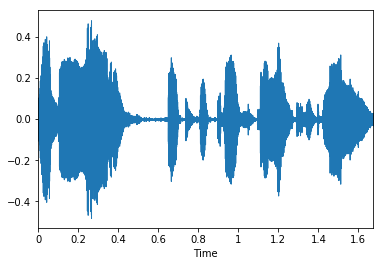

In [4]:
audio = audio.unsqueeze(0)
audio_plain = audio.numpy()[0, 0]
print(audio_plain)
plt.figure()
librosa.display.waveplot(audio_plain)

In [5]:
audio.shape

torch.Size([1, 1, 36925])

In [6]:
# Prepare model
vae_model = VAE(
    input_shape=(1, 1, args.input_max_len),
    encoder_arch=args.encoder,
    num_latents=args.num_latents,
    generator_arch=args.generator,
    num_speakers=109)

# Select epoch
epoch = 1

# Load model from state
vae_experiment = VAEExperimentBuilder(network_model=vae_model,
                                    experiment_name=args.experiment_name,
                                    weight_decay_coefficient=args.weight_decay_coefficient,
                                    learning_rate=args.learning_rate,
                                    commit_coefficient=args.commit_coefficient,
                                    device=torch.device('cpu'),
                                    continue_from_epoch=epoch,
                                    train_data=None,
                                    val_data=None,
                                    test_data=None,
                                    num_epochs=None)

Building VAE.
Building Encoder with 4 downsampling layers.
torch.Size([1, 1, 20000])
torch.Size([1, 16, 6665])
torch.Size([1, 32, 2220])
torch.Size([1, 64, 738])
torch.Size([1, 64, 244])
torch.Size([1, 64, 244]) and torch.Size([1, 64, 244])
Building Decoder/Generator with 5 upsampling layers.
torch.Size([1, 64, 244])
torch.Size([1, 64, 730])
torch.Size([1, 64, 2196])
torch.Size([1, 32, 6604])
torch.Size([1, 32, 19903])
torch.Size([1, 32, 20000])
torch.Size([1, 64, 20000])
torch.Size([1, 64, 20000])
torch.Size([1, 1, 20000])
/Users/simon/mlpcw/experiments/vae_lr1e-2 /Users/simon/mlpcw/experiments/vae_lr1e-2/result_outputs
Loading model train_model, at epoch 1.


In [7]:
args.eval_speaker_id = 94
# Prepare speaker tensor
speaker_id = torch.tensor(args.eval_speaker_id, dtype=torch.long)

In [8]:
vae_experiment.model.encoder.layer_dict.mean_latent_conv.weight.data.dtype

torch.float32

In [9]:
vae_experiment.model.generator.layer_dict.logit_conv.weight.data.dtype

torch.float32

In [10]:
vae_experiment.model.generator.speaker_dict.weight

Parameter containing:
tensor([[ 8.3085e-01,  1.1923e+00, -1.6205e-01, -1.0961e-01,  1.0630e+00,
         -5.0657e-01,  8.8752e-01, -5.6152e-03,  9.5542e-01, -1.0750e+00,
         -1.3493e-01,  4.9761e-01, -1.3661e+00,  1.7950e+00, -6.4596e-01,
         -1.0970e+00,  1.3698e+00, -5.4216e-02,  9.1059e-01,  1.6086e-01,
          1.5143e-01, -1.1598e-01, -1.1570e+00,  6.7195e-01, -2.3041e+00,
         -4.7473e-01,  7.1203e-01,  1.2979e-01, -9.4363e-01, -1.0594e+00,
         -4.1935e-01, -2.2465e-01, -5.2743e-01, -4.7162e-01,  1.6040e+00,
         -1.3679e-01,  1.4037e+00, -1.4572e+00,  8.4833e-01,  1.4566e+00,
         -7.7726e-01, -9.1369e-01,  6.2508e-01, -1.2975e+00, -8.1616e-02,
         -1.0716e-01, -4.8638e-01,  5.0356e-01,  1.0787e-01, -1.9869e+00,
          1.2755e+00,  2.1908e-01,  7.1362e-01, -1.4142e+00, -9.0214e-01,
          5.5793e-01, -9.7747e-01, -1.3628e-02,  3.7157e-01, -8.1469e-01,
          1.1855e+00, -5.7238e-01, -1.6893e-01,  5.3107e-01],
        [ 4.4457e-01,  5.994

In [17]:
out = vae_experiment.convert(x=audio, y=speaker_id)
print(out.shape)

torch.Size([1, 1, 36929])


In [18]:
audio.shape

torch.Size([1, 1, 36925])

[-3.3873988e-05 -3.1500207e-05 -2.5302332e-05 ... -2.4006993e-05
 -3.1013238e-05 -3.3718345e-05]


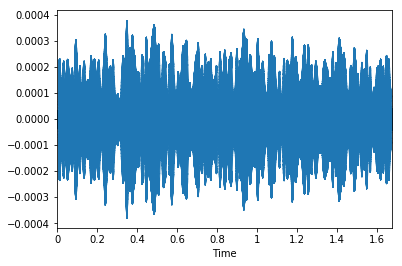

In [19]:
#out = out.squeeze(0)
out_plain = out.numpy()[0, 0]
print(out_plain)
plt.figure()
librosa.display.waveplot(out_plain)

In [20]:
out.shape

torch.Size([1, 1, 36929])

In [22]:
out_path = os.path.expanduser(args.eval_out_path)
out_filename = '{}_{}_{}.wav'.format(os.path.basename(args.eval_audio_path).split('.')[0], args.eval_speaker_id, epoch)
out_file_path = os.path.join(out_path, out_filename)

# Save as audio
torchaudio.save(filepath=out_file_path, src=out.squeeze(1), sample_rate=sr)
